Using the main.ipynb for training Transformers was too chaotic for me. This file will be ONLY contain code that is absolutely necessary for finding out how to train the Transformer model.

In [72]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 267, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 267 (delta 3), reused 0 (delta 0), pack-reused 256 (from 1)
Receiving objects: 100% (267/267), 9.23 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (150/150), done.
/content/bsc-thesis/src
backtesting/  data/       main.py  preprocessing/
config/       main.ipynb  models/  utils/


In [73]:
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

In [74]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import itertools

# Custom Imports
from models.statistical_models import create_dataset
from data.data_collection import gather_data
from data.scraper import load_cached_etf_tickers
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

In [75]:
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2010-10-01'
endDateStr = '2024-10-02' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
pairs_data = {key:value[1]  for (key, value) in pairs.items()}
pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

[*********************100%***********************]  777 of 777 completed
ERROR:yfinance:
142 Failed downloads:
ERROR:yfinance:['PCMM', 'SEIS', 'PQJL', 'QQLV', 'HOOX', 'SOLZ', 'ENDW', 'RAA', 'TSMU', 'IONL', 'FEAT', 'VRTL', 'BRKU', 'GLCR', 'SPCY', 'IBTQ', 'CRMG', 'USAF', 'GFLW', 'CORO', 'ARMG', 'TAX', 'OOQB', 'HIMZ', 'RDTY', 'BMAX', 'CRWL', 'EVYM', 'IBGB', 'FMUB', 'MUU', 'TQQY', 'GLDY', 'EBI', 'VBIL', 'SOLT', 'YSPY', 'TSMG', 'SEIE', 'TSLG', 'MCDS', 'TPLS', 'THMZ', 'ZAP', 'BUFM', 'AVL', 'SLVR', 'QCML', 'ADBG', 'TXUE', 'HEQQ', 'SEEM', 'KPDD', 'SMCZ', 'DVQQ', 'FMUN', 'QNXT', 'AFSC', 'PANG', 'APED', 'BCLO', 'QTOP', 'TEKY', 'HFSP', 'LFSC', 'TSYY', 'RKLX', 'HOOG', 'CHGX', 'AVGB', 'AMDG', 'BRKD', 'HWAY', 'VOLT', 'TSEL', 'PQAP', 'AMUU', 'ZIPP', 'PLTU', 'COIG', 'SMCL', 'PYPG', 'WTMU', 'YOKE', 'TSMX', 'IBGL', 'QDTY', 'BEEX', 'ALIL', 'ELFY', 'EGGQ', 'PQOC', 'INTW', 'ORCX', 'TSMZ', 'GIND', 'PEPS', 'JPY', 'BAFE', 'MRAL', 'OOSB', 'PLTD', 'NVDG', 'AVS', 'ELIL', 'ASMG', 'SDTY', 'TXUG', 'NFXS', 'NATO', '

Completed 1711 pairs


/content/bsc-thesis/src/preprocessing/technical_indicators.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_c = -sm.OLS(df['S1_close'], df['S2_close']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:97: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha_o = -sm.OLS(df['S1_open'], df['S2_open']).fit().params[0]
/content/bsc-thesis/src/preprocessing/technical_indicators.py:98: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by po

In [ ]:
# save variable `data` somewhere
import pickle
with open('data_2010_10_01_2024_10_02_142_failed.pkl', 'wb') as f:
    pickle.dump(data, f)



In [76]:
# Set a bunch of variables based on the existing function `execute_kalman_workflow` (Note: Some are changed already)
pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 64
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = False

torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.001456 | val MSE 0.052730
Epoch 020 | train MSE 0.001092 | val MSE 0.044250
Epoch 030 | train MSE 0.001229 | val MSE 0.054674
Epoch 040 | train MSE 0.001118 | val MSE 0.054499
Epoch 050 | train MSE 0.000916 | val MSE 0.044368
Epoch 060 | train MSE 0.000731 | val MSE 0.063017
Epoch 070 | train MSE 0.000766 | val MSE 0.039898
Epoch 080 | train MSE 0.000879 | val MSE 0.039807
Epoch 090 | train MSE 0.000882 | val MSE 0.040098
Epoch 100 | train MSE 0.000849 | val MSE 0.047417
Epoch 110 | train MSE 0.000731 | val MSE 0.040495
Epoch 120 | train MSE 0.000816 | val MSE 0.038259
Epoch 130 | train MSE 0.000719 | val MSE 0.043367
Epoch 140 | train MSE 0.000741 | val MSE 0.035769
Epoch 150 | train MSE 0.000712 | val MSE 0.037121
Epoch 160 | train MSE 0.000704 | val MSE 0.039082
Epoch 170 | train MSE 0.000628 | val MSE 0.046397
Epoch 180 | train MSE 0.000763 | val MSE 0.044233
Epoch 190 | train MSE 0.000798 | val MSE 0.041401
Epoch 200 | train MSE 0.0

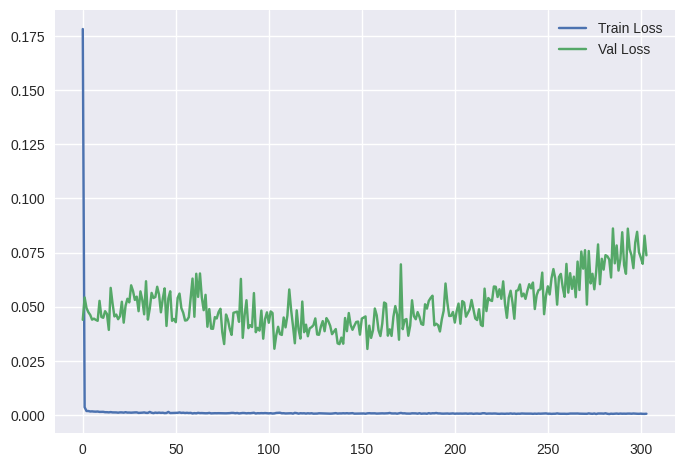

Test MSE  : 12.356597


In [77]:
# def execute_transformer_workflow
if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_burned[:train_size]
dev   = pairs_timeseries_burned[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned[train_size+dev_size:]

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

if denoise_fn is not None: # denoise using wavelet denoising
    train = pd.DataFrame({col: denoise_fn(train[col]) for col in train.columns}) # TODO: unsure whether dev and test should also be denoised?

x_scaler = scaler_factory(**scaler_kwargs) # important: the scaler learns parameters, so separate objects must be created for x and y
y_scaler = scaler_factory(**scaler_kwargs)

# We want a sliding window in our dataset
# TODO: defining this function should not be part of workflow, but imported from a custom module
def create_sliding_dataset(mat: np.ndarray,
                           x_scaler: MinMaxScaler,
                           y_scaler: MinMaxScaler,
                           look_back: int = 20):
    """
    X  -> (samples, look_back, features)
    y  -> (samples, 1)   — the next-step Spread_Close (just 1 day in advance)
    """
    X, y = [], []
    for i in range(len(mat) - look_back):
        X.append(mat[i : i + look_back, :]) # window
        y.append(mat[i + look_back, 0]) # value right after the window
    X, y = np.array(X), np.array(y).reshape(-1, 1)

    # scale per feature (fit on the training set once!)
    X_scaled = x_scaler.fit_transform(
        X.reshape(-1, X.shape[-1])
    ).reshape(X.shape)
    y_scaled = y_scaler.fit_transform(y)

    return X, X_scaled, y, y_scaled

trainX_raw, trainX_scaled, trainY_raw, trainY_scaled = create_sliding_dataset(
    train.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back) # train_X_scaled.shape: (2219, 20, 34) // [(t - look_back), look_back, features]
devX_raw,   devX_scaled,   devY_raw,   devY_scaled   = create_sliding_dataset(
    dev.values,  x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)
testX_raw,  testX_scaled,  testY_raw,  testY_scaled  = create_sliding_dataset(
    test.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)


# use pytorch Dataset class
class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        #  cast to float32 once to avoid repeated conversions
        self.X = torch.tensor(X, dtype=torch.float32)      # (N, L, F)
        self.y = torch.tensor(y, dtype=torch.float32)      # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]                    # each X: (L, F)

train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True,  drop_last=True,  num_workers=0)
dev_loader   = DataLoader(dev_ds,   batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)

print(next(iter(train_loader))[0].shape)   # torch.Size([64, 20, 34]) //  (batch_size, look_back, features)

class TimeSeriesTransformerv1(nn.Module):
  """
  This version (v1) uses:
  * learnable positional embeddings (simple, so no RoPE and no sinusoidal)
  * only an encoder (followed by a regression head that transforms from form (seq_len, d_model) into (1), with the output form being the Spread_Close prediction)
  """
  def __init__(
      self,
      n_features: int,
      seq_len: int,
      d_model: int = 128,
      nhead: int = 8,
      num_layers: int = 4,
      dropout: float = 0.1,
  ):
      super().__init__()
      self.seq_len = seq_len

      # token projection (linear layer)
      self.input_proj = nn.Linear(n_features, d_model)

      # learnable positional embedding  (1, seq_len, d_model)
      self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

      # encoder (important part)
      enc_layer = nn.TransformerEncoderLayer(
          d_model=d_model,
          nhead=nhead,
          dim_feedforward=d_model * 4,
          dropout=dropout,
          batch_first=True, # keeps (batch, seq, dim)
      )
      self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

      # regression head (mainly helps in getting to the right output format)
      self.head = nn.Sequential(
          nn.Flatten(start_dim=1), # (batch, seq_len*d_model)
          nn.Linear(seq_len * d_model, 128),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(128, 1),
      )

  def forward(self, x): # x: (batch, seq_len, n_features)
      x = self.input_proj(x) + self.pos_emb
      x = self.encoder(x) # (batch, seq_len, d_model)
      return self.head(x) # (batch, 1)

n_features = trainX_scaled.shape[-1]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model  = TimeSeriesTransformerv1(
            n_features=n_features,
            seq_len=look_back,
            d_model=128,
            nhead=8,
            num_layers=4,
            dropout=0.1).to(DEVICE)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

EPOCHS    = 400 # TODO: make params like these customizeable in the func params + might be a bit low?
PATIENCE  = 150

# implement the early stopping logic manually
best_val = float("inf")
epochs_no_improve = 0
print_per_n = 10

# save train_loss and val_loss to lists for plotting
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x_batch).squeeze(-1)
        loss  = criterion(preds, y_batch.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
    train_losses.append(train_loss)

    model.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dev_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds  = model(x_batch).squeeze(-1)
            running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
    val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
    val_losses.append(val_loss)

    # print losses in a pretty way
    if epoch % print_per_n == 0:
      print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


    # manual early stopping logic
    if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
        best_val = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

### Plotting #####
# TODO: remove plotting when implementing into actual workflow function
# but for now, plot train_losses and val_losses
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.show()
### Plotting #####

# Now, let's run the model on the testset
# made sure we're in eval mode
model.eval()

all_preds, all_targets = [], []
with torch.no_grad(): # note for myself: torch.no_grad() makes sure that individual weights are not stored in memory, because we would only need to know those during learning, not during inference
    for x_test_batch, y_test_batch in test_loader:
      x_test_batch = x_test_batch.to(DEVICE)
      preds = model(x_test_batch) # make predictions using model
      # transform the preds and targets back to numpy, as these need to be inverted with the scaler, which expects numpy not tensors
      preds = preds.cpu().numpy()
      y_test_batch = y_test_batch.cpu().numpy()
      all_preds.append(preds)
      all_targets.append(y_test_batch)

# maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
y_hat_scaled = np.concatenate(all_preds).reshape(-1, 1)
y_true_scaled = np.concatenate(all_targets).reshape(-1, 1)

y_hat = y_scaler.inverse_transform(y_hat_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

test_mse = np.mean((y_hat - y_true) ** 2)
print(f"Test MSE  : {test_mse:.6f}")

## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
# give same output as was originally the case
forecast = None
transformer_spread = None
output: Dict[str, Any] = dict(
    mse=test_mse,
    forecast=forecast,
    result=transformer_spread # the predicted spread
)

if return_datasets:
    output.update(
        dict(train=train, dev=dev, test=test,
              datasets=dict(
                  train=(trainX_raw, trainX_scaled, trainY_raw, trainY_scaled),
                  dev  =(devX_raw,   devX_scaled,   devY_raw,   devY_scaled),
                  test =(testX_raw,  testX_scaled,  testY_raw,  testY_scaled)
              ))
    )
# return output

Simulated P&L: -230323.42146599287


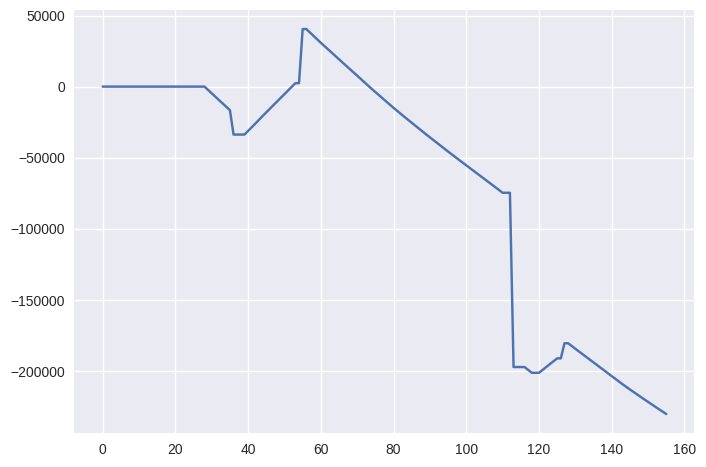

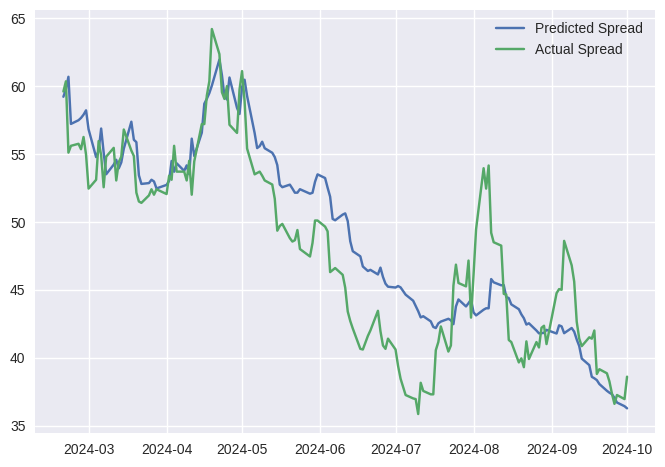

In [78]:
def trade(
    S1: pd.Series,
    S2: pd.Series,
    spread: pd.Series, # model-predicted spread, used for the strategy
    window_long: int, # long time-span moving-average window (and window used for stdev) (e.g. 60)
    window_short: int, # short time span moving-average window (e.g. 5)
    position_threshold: float = 1.0,
    clearing_threshold: float = 0.5
) -> float: # simulated profit-and-loss
    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    cash, qty_s1, qty_s2 = 0.0, 0, 0
    returns = []

    for i in range(len(spread)):
      # go through zscore for each timestep
      if zscore.iloc[i] > position_threshold: # option 1: sell short
        cash += S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
        qty_s1 -= 1
        qty_s2 += spread.iloc[i] # following the classic pairs-trade: this buys β shares in the case that spread_t = S1_t + β * S2_t
      elif zscore.iloc[i] < -position_threshold: # option 2: buy long
        cash -= S1.iloc[i] - S2.iloc[i] * spread.iloc[i]
        qty_s1 += 1
        qty_s2 -= spread.iloc[i] # same as bove, but other way around
      elif abs(zscore.iloc[i]) < clearing_threshold: # option 3: go neutral, clearing all positions
        cash += qty_s1 * S1.iloc[i] - qty_s2 * S2.iloc[i] # Closing on S1 is gained (we make a profit if we have a positive amount of S1, which we sell), closing on S2 is lost (we need to buy back the shorted positions, losing cash)
        qty_s1, qty_s2 = 0, 0
      returns.append(cash)
    return returns

spread_pred_series = pd.Series(y_hat.squeeze(), index=test.index[look_back:])  # align lengths
spread_gt_series = pd.Series(y_true.squeeze(), index=test.index[look_back:])
returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_pred_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 1.0,
    clearing_threshold = 0.5
)
print("Simulated P&L:", returns[-1])

# plot returns
plt.plot(returns)
plt.show()

# plot predicted vs actual spreads
plt.plot(spread_pred_series, label='Predicted Spread')
plt.plot(spread_gt_series, label='Actual Spread')
plt.legend()
plt.show()

Simulated P&L: 93200.76144465664
Return % over period: -6.799238555343356%
Return % YoY: -15.10050338441623


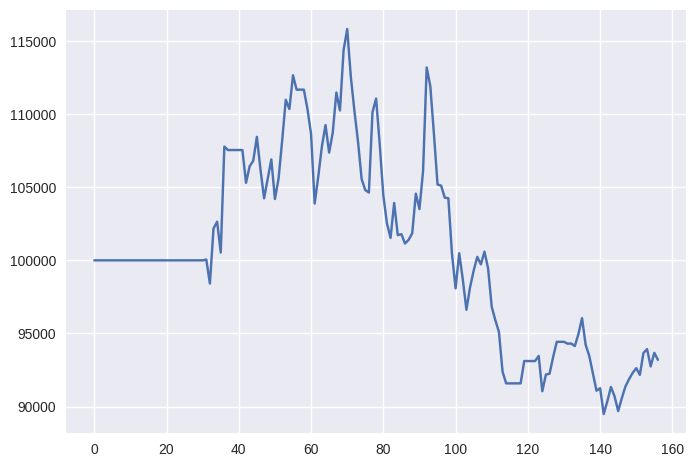

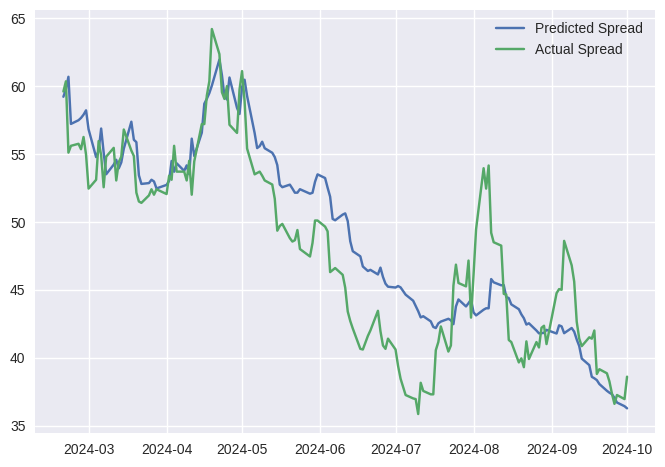

In [79]:
def trade(
    S1: pd.Series,
    S2: pd.Series,
    spread: pd.Series, # model-predicted spread for the strategy
    window_long: int,
    window_short: int,
    initial_cash: float = 100000,
    position_threshold: float = 1.0,
    clearing_threshold: float = 0.5,
    risk_fraction: float = 0.1
) -> list:
    ma_long = spread.rolling(window=window_long, center=False).mean()
    ma_short = spread.rolling(window=window_short, center=False).mean()
    std = spread.rolling(window=window_short, center=False).std()
    zscore = (ma_long - ma_short)/std

    cash = initial_cash
    qty_s1 = 0
    qty_s2 = 0
    returns = [initial_cash]
    position = 0 # 0: neutral, 1: long, -1: short

    for i in range(len(spread)):
        price_s1 = S1.iloc[i]
        price_s2 = S2.iloc[i]
        beta = spread.iloc[i]
        equity = cash + qty_s1 * price_s1 - qty_s2 * price_s2

        # Enter short spread (short S1, long beta S2)
        if position == 0 and zscore.iloc[i] > position_threshold:
            position = -1
            position_size = equity * risk_fraction
            qty_s1 = -position_size / price_s1
            qty_s2 = (position_size * beta) / price_s2
            cash -= (qty_s1 * price_s1 - qty_s2 * price_s2)

        # Enter long spread (long S1, short beta S2)
        elif position == 0 and zscore.iloc[i] < -position_threshold:
            position = 1
            position_size = equity * risk_fraction
            qty_s1 = position_size / price_s1
            qty_s2 = - (position_size * beta) / price_s2
            cash -= (qty_s1 * price_s1 - qty_s2 * price_s2)

        # Exit to neutral when spread reverts
        elif position != 0 and abs(zscore.iloc[i]) < clearing_threshold:
            cash += qty_s1 * price_s1 - qty_s2 * price_s2
            qty_s1 = 0
            qty_s2 = 0
            position = 0

        equity = cash + qty_s1 * price_s1 - qty_s2 * price_s2
        returns.append(equity)

    return returns

spread_pred_series = pd.Series(y_hat.squeeze(), index=test.index[look_back:])  # align lengths
spread_gt_series = pd.Series(y_true.squeeze(), index=test.index[look_back:])
returns = trade(
    S1 = test['S1_close'].iloc[look_back:],
    S2 = test['S2_close'].iloc[look_back:],
    spread = spread_pred_series,
    window_long = 30,
    window_short = 5,
    position_threshold = 1.0,
    clearing_threshold = 0.5
)
print("Simulated P&L:", returns[-1])
print(f"Return % over period: {100*((returns[-1] - returns[0]) / returns[0])}%")
print(f"Return % YoY: {((returns[-1] / returns[0])**(365/len(returns)) - 1) * 100}")

# plot returns
plt.plot(returns)
plt.show()

# plot predicted vs actual spreads
plt.plot(spread_pred_series, label='Predicted Spread')
plt.plot(spread_gt_series, label='Actual Spread')
plt.legend()
plt.show()

To get a more reliable plot, we will test out a set of different threshold combinations to be able to plot uncertainty / standard deviation in our returns.



Returns for (pt=0.5,ct=0.1) -> 138967.47147477057
Returns for (pt=0.5,ct=0.13333333333333336) -> 138967.47147477057
Returns for (pt=0.5,ct=0.16666666666666669) -> 141266.4505319344
Returns for (pt=0.5,ct=0.2) -> 137718.09336183756
Returns for (pt=0.5,ct=0.23333333333333336) -> 137718.09336183756
Returns for (pt=0.5,ct=0.2666666666666667) -> 98137.155115804
Returns for (pt=0.5,ct=0.30000000000000004) -> 96408.41956992057
Returns for (pt=0.5,ct=0.33333333333333337) -> 96408.41956992057
Returns for (pt=0.5,ct=0.3666666666666667) -> 96408.41956992057
Returns for (pt=0.5,ct=0.4) -> 96408.41956992057
Returns for (pt=0.5666666666666667,ct=0.1) -> 138967.47147477057
Returns for (pt=0.5666666666666667,ct=0.13333333333333336) -> 138967.47147477057
Returns for (pt=0.5666666666666667,ct=0.16666666666666669) -> 141266.4505319344
Returns for (pt=0.5666666666666667,ct=0.2) -> 137718.09336183756
Returns for (pt=0.5666666666666667,ct=0.23333333333333336) -> 137718.09336183756
Returns for (pt=0.56666666

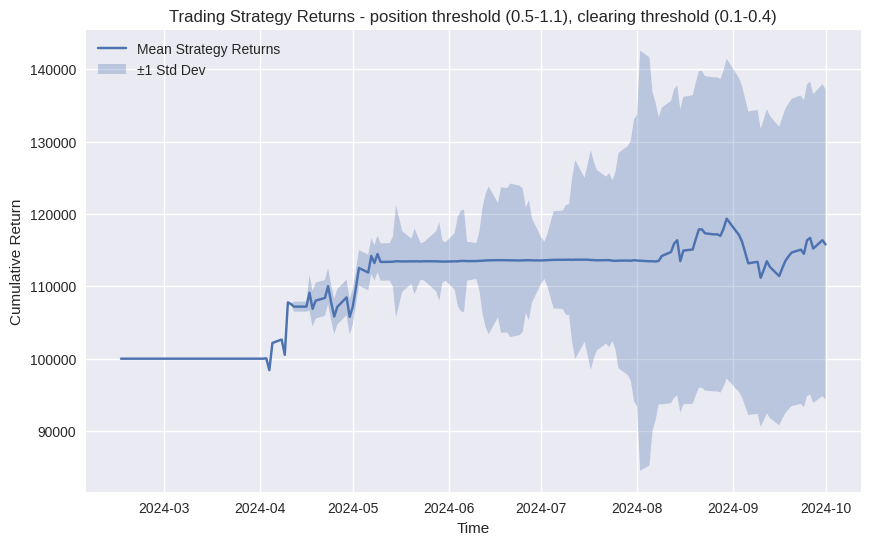

In [80]:
position_thresholds = np.linspace(0.5, 1.1, num=10)
clearing_thresholds = np.linspace(0.1, 0.4, num=10)
threshold_combinations = list(itertools.product(position_thresholds, clearing_thresholds))

# for pos_thres, clr_thres in threshold_combinations:
# long_windows = [20, 25, 30, 40, 50]
# short_windows = [2, 3, 5, 7]
# window_combinations = list(itertools.product(long_windows, short_windows))

all_returns = []

# for window_long, window_short in window_combinations:
for pos_thres, clr_thres in threshold_combinations:
    returns = trade(
        S1 = test['S1_close'].iloc[look_back:],
        S2 = test['S2_close'].iloc[look_back:],
        spread = spread_pred_series,
        # window_long = window_long,
        # window_short = window_short,
        window_long = 30,
        window_short = 5,
        position_threshold = pos_thres,
        clearing_threshold = clr_thres
    )
    all_returns.append(returns)
    # print(f"Returns for (wl={window_long},ws={window_short}) -> {returns[-1]}")
    print(f"Returns for (pt={pos_thres},ct={clr_thres}) -> {returns[-1]}")

# turn into numpy
returns_array = np.vstack([np.array(r) for r in all_returns])

# mean and stdev for plotting
mean_returns = returns_array.mean(axis=0)
std_returns = returns_array.std(axis=0)
time_axis_series = test.index[look_back - 1:]

std_dev_pct = (std_returns / mean_returns[0]) * 100

print(f"Return % over period: {100 * ((mean_returns[-1] - mean_returns[0]) / mean_returns[0]):.2f}% ± {std_dev_pct[-1]:.2f}%")
print(f"Return % YoY (mean and std dev): {((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1) * 100:.2f}% ± {((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns))) * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(time_axis_series, mean_returns, label='Mean Strategy Returns')
plt.fill_between(time_axis_series, mean_returns - std_returns, mean_returns + std_returns, alpha=0.3, label='±1 Std Dev')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
# plt.title('Trading Strategy Returns - short window (2-7), long window (20-50)')
plt.title(f"Trading Strategy Returns - position threshold (0.5-1.1), clearing threshold (0.1-0.4)")
plt.legend()
plt.show()

Some examples of outputs for understanding the form of the data better:

`len(trainX_untr)`
```
2238
```

`len(trainX_untr[0])`
```
34
```

Context: The 34 features consist of
* 10 technical indicators for both S1 and S2 (total 20)
* S1_close/open/high/low/volume, same for S2 (total 10)
* Pair spreads: close, open, high, low (total 4)


`trainX_untr[0] `
```
array([ 2.76970068e+01,  4.91006247e+01,  2.89730484e+01,  4.91027293e+01,
        2.89891358e+01,  4.91343834e+01,  2.60513431e+01,  4.87784465e+01,
        5.03546207e+05,  7.43386097e+03,  4.49718063e+01,  5.82671806e+01,
        5.75577766e+01,  8.28358144e+01,  7.59406546e+01,  3.92425336e+02,
        1.05376719e+05, -9.14930577e+03,  1.56861725e+00,  7.63660812e-01,
        2.85638197e+01,  4.83799321e+01,  8.30115861e+00,  2.65305580e+01,
        2.84687992e+01,  4.85740999e+01,  2.27306259e-01,  4.38795633e-02,
       -1.31033890e+00,  1.00654755e-01, -6.89227038e+00, -5.61453974e+00,
       -5.72867758e+00, -8.18838280e+00])
```

`len(trainY_untr)`
```
2238
```


`len(trainY_untr)[0]`
```
1
```

`trainY_untr[0]`
```
array([27.81830352])
```

`trainY_untr[:20]`
```
[array([27.81830352]),
 array([27.42025825]),
 array([25.9191175]),
 array([22.98625305]),
 array([20.5661885]),
 array([21.23151271]),
 array([24.11603916]),
 array([25.605551]),
 array([26.16966699]),
 array([26.46204422]),
 array([25.33065673]),
 array([25.72835342]),
 array([25.91998167]),
 array([25.70591191]),
 array([25.83366537]),
 array([26.33152235]),
 array([26.35160811]),
 array([26.2352556]),
 array([26.03820719]),
 array([25.75521362])]
 ```

`trainX_sliding.shape` (when using look_back=20)

```
 (2219, 20, 34)
```
